In [1]:
import numpy as np
import pandas as pd
import math
import scipy as sp
import matplotlib.pyplot as plt
from IPython.display import display
import sys
import pickle
import seaborn
seaborn.set_style('ticks')
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

####Generate a mixing matrix for use in metapopulation code###
* Size will be npatchxnpatch
* Dispersion kernel defined by:  
$ p(d) = \frac{1}{N} \exp\left(-(d/\alpha)^c\right)$  
$\alpha$ sets the length scale of dispersion, and $c$ adjusts the 'tail fatness.' Higher $c$ means fatter (skinnier??) tails. $d$ is the distance between the points.
* Normalization constant is:  
$N = \frac{2\pi \alpha^2 \Gamma(2/c)}{c}$


In [2]:
#Set constants for the matrix you want.
n = 20         #size of an edge (even numbers make the movie easier)
npatch = n*n   #npatch is nxn - the matrix is npatchxnpatch
alpha = 1.     #length scale
cinj = 0.5        #tail weight (lower c -> higher tail weight)

In [3]:
def distance(x1,x2,y1,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
def kernel(d,a,c):
    N = 2.*np.pi*a*sp.special.gamma(1./c)/c
    pofd = np.exp(-((d/a)**c))
    return pofd/N

/Users/laurasampson/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


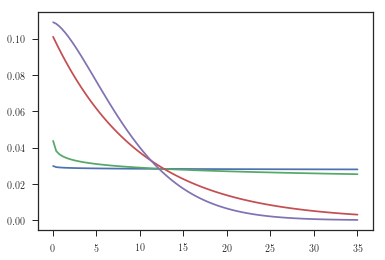

In [4]:
dist = np.linspace(0.05,35,100) #For normalization purposes, should neighboring cells be 'zero'? (Yes.)
dx = dist[1]-dist[0]

ctest = [0.01,0.1,1.0,1.5]
alpha = 10.
for cinj in ctest:
    k = kernel(dist,alpha,cinj)
    k /= sum(k*dx)   #Normalize
    plt.plot(dist,k)

In [6]:
#For a given alpha and c, you want to output an npatchxnpatch matrix with k giving the values of each cell. 
#You should only have to calculate k once - it just gets 'shifted' for each new row. The trick is to calculate 
#the distance between each point in the row. If i=j, this kernel should be the non-mixed value. Say 0.1, whatever. It's
#going to get scaled anyway.
cinj = 10.0
alpha = 10.
mixmat = np.zeros([n,n])
mixmat += 0.00001
betamat = []
for istar in range(n):
    for jstar in range(n):
        for i in range(n):
            for j in range(n):
                dist = np.abs(np.sqrt((i-istar)**2+(j-jstar)**2)-1.) #scaled so nearest (non-diagonal) neighbors are zero distance.
                if dist<=0:
                    dist = 0.05
                if (i==istar)&(j==jstar):
                    dist = 0.05
                k = kernel(dist,alpha,cinj)
                mixmat[i,j] = k
                
                #To generate a diagonal mixing matrix:
                '''
                if i==j:
                    mixmat[i,j] = 1.
                else:
                    mixmat[i,j] = 0.
                '''
        mixvec = mixmat.flatten()
        if istar==19 and jstar==19:
            print mixmat
        betamat.append(mixvec)
betamat = np.array(betamat)

[[  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    1.03161990e-305   1.99345255e-258   3.16906735e-223   2.01961367e-197
    4.43358160e-179   7.51544164e-167   7.57992018e-160   1.44563290e-157]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   9.26519958e-287   2.56746682e-229
    9.21589946e-187   2.59275888e-155   3.23483216e-132   1.73023289e-115
    1.02011059e-103   6.23538100e-096   1.69792036e-091   4.67710162e-090]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    1.03161990e-305   2.05801721e-232   4.43358160e-179   2.89828293e-140
    5.10542784e-112   1.69792036e-09

In [33]:
#Need to scale so that the population mixing isn't explicitly affecting R0. Set maximum eigenvalue to 1.0.
R0 = 1.
gamma = 1.                  #Number of timesteps to recovery. Our timesteps are two weeks long, so this is just one.
maxeig = R0*gamma

for i in range(n*n):
    trial = betamat[i,:].copy()                       #mixing matrix associated with individual cell
    trial = trial.reshape(n,n)
    scale = np.real(np.max(np.linalg.eigvals(trial)))
    betamat[i,:] *= 1./scale                          #Scale so the maximum eigenvalue *of each matrix* is 1.0

trial = betamat[0,:].copy()                  
trial = trial.reshape(n,n)
print np.max(np.linalg.eigvals(trial))      #check the maximum eigenvalue is 1.0 (and real...)

1.0


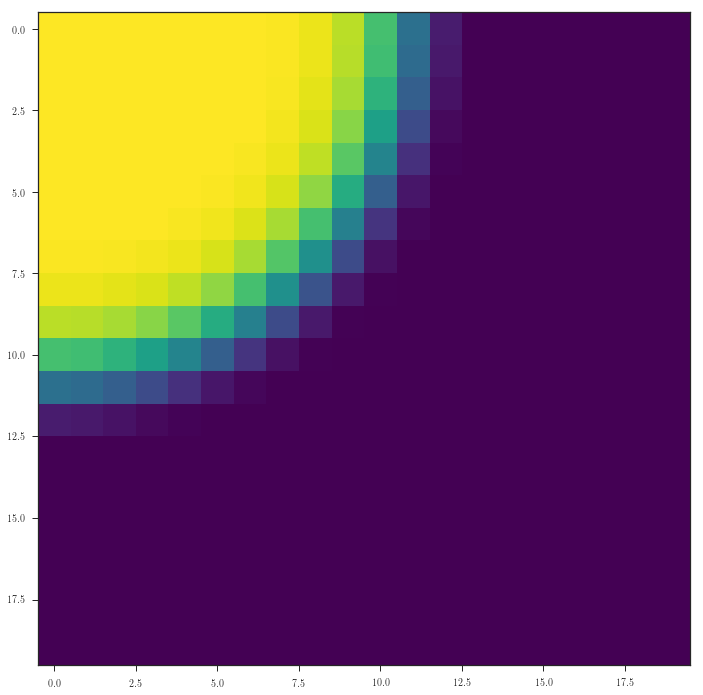

In [34]:
plt.figure(figsize=(12,12))
plt.imshow(trial,cmap='viridis',interpolation='none')

In [ ]:
filename = 'mixingMatrices/alpha10c10.0.hpp'
with open(filename,"w") as f:
    f.write("static std::array<std::array<float, nptch>, nptch> sbetaMatrix = {{\n")
    for row in betamat:
        f.write("{{")
        for i in range(npatch-1):
            f.write(str(row[i])+",")
        f.write(str(row[npatch-1])+"}},\n")
    f.write("}};")